In [1]:
# This code snippet would help to access module of upper directory

import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
print (sys.path)

from read_utils import load_one_param_file

a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)
print (sys.path)



['', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\python35.zip', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\DLLs', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib', 'C:\\Anaconda3\\envs\\tensorflow-cpu', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Tuan Do\\.ipython', 'D:\\git\\learn-to-perform']
['', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\python35.zip', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\DLLs', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib', 'C:\\Anaconda3\\envs\\tensorflow-cpu', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages', 'C:\\Anaconda3\\envs\\tensorflow-cpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Tuan Do\\.ipython', 'D:\\git\\learn-to-perform', 'D:\\git\\learn-to-perform\\strands_qsr_lib\\qsr_lib\\src3']


In [3]:
from feature_util import qsr_feature_extractor

In [4]:
from utils import DATA_DIR, FIRST_EXPERIMENT_CLASSES,\
    SESSION_NAME, SESSION_OBJECTS, SESSION_EVENTS, GLYPH_BOX, NORMAL, \
    START, END, LABEL

In [61]:
session_data = load_one_param_file(os.path.join( DATA_DIR, 'SlideAround', 'Session1', 'files.param'))

'NoneType' object has no attribute 'findall'


In [92]:
%matplotlib inline

import numpy as np
from feature.project_table import project_markers, estimate_cube_2d
from simulator.utils import Cube2D, Transform2D
from matplotlib import pyplot as plt
from matplotlib import animation

def count_finite( numpy_array ):
    return np.sum( np.isfinite( numpy_array )) 

'''
Area of polygons
===========
Params: numpy_array of size ( 3 x n )

Return: object_data: Dictionary
'''
def area_dimension( numpy_array ):
    s = np.reshape(numpy_array, (len(numpy_array)//3,3))
    x = s[:,0]
    y = s[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def project_to2d_ ( session_data ):
    object_data = {}

    for object_name in session_data[SESSION_OBJECTS]:
        if object_name == 'table':
            polygon = []
            for frameNo in session_data[SESSION_OBJECTS][object_name]:
                frame_polygon = session_data[SESSION_OBJECTS][object_name][frameNo]

            polygon.append(frame_polygon)

            polygon = np.concatenate(polygon)
            polygon = np.reshape(polygon, (len(polygon)//3, 3) )
            
            table_markers = polygon

            # Just pick the first two points for coordination
            first_point = table_markers[0]
            second_point = table_markers[1]
    
    for object_name in session_data[SESSION_OBJECTS]:
        if object_name != 'table':
            object_data[object_name] = {}
            for frameNo in session_data[SESSION_OBJECTS][object_name]:
                frame_data = session_data[SESSION_OBJECTS][object_name][frameNo]

                # Sort firstly by number of non-finite corners
                # Sort secondly by size of marker (larger marker means better resolution)
                # Size of marker should be only based on first two dimensions
                # The third dimension might be very noisy
                q = [((count_finite(frame_data[face_index]), area_dimension(frame_data[face_index]) ), face_index) 
                    for face_index in frame_data]
                q = sorted(q, key = lambda t: t[0], reverse = True)

                # Pick out the face_index with the most number of non-infinite values
                best_face_index = q[0][1]
                #print ('-----------')
                #print (frame_data[best_face_index])
                rectangle_projected = project_markers ( frame_data[best_face_index], table_markers )
                #print (rectangle_projected)
                
                try:
                    object_data[object_name][int(frameNo)] = estimate_cube_2d ( rectangle_projected, first_point, second_point )
                except:
                    continue

    return object_data

def make_lines(shape):
    lines = []
    for i in range(len(shape)):
        j = (i + 1) % len(shape)
        lines.append( [ shape[i], shape[j] ] )
    
    return lines





In [62]:
'''
Demo the movement of objects in a session from from_frame to to_frame (inclusive)
'''

object_data = project_to2d_(session_data)

D:\git\learn-to-perform\feature\project_table.py:116: RuntimeWarning: invalid value encountered in true_divide
  side /= norm(side)
C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\numpy\linalg\linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars


In [13]:
print (object_data['Shell'][2].transform.position)
print (object_data['Shell'][2].transform.rotation)

[[ 0.13866424  0.41743544]]
1.415809321622445


In [39]:
import pylab as pl
from matplotlib import collections as mc

def plot (object_data, from_frame, to_frame):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(-2, 2, 0.1))
    ax.set_yticks(np.arange(-2, 2, 0.1))
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    fig.set_size_inches(20, 12)
    
    for object_name in object_data:
        data = object_data[object_name]
        
        for frameNo in data:
            if from_frame  <= frameNo <= to_frame :
                # Mistake
                # data[frameNo].transform.scale = data[frameNo].transform.scale / 2
                shape = data[frameNo].get_markers()
                
                lc = mc.PolyCollection([shape], edgecolors=[colors[object_name]], 
                                       facecolors=[colors[object_name]], linewidths=[2])
                ax.add_collection(lc)


    ax.autoscale()
    ax.margins(0.1)

    plt.show()

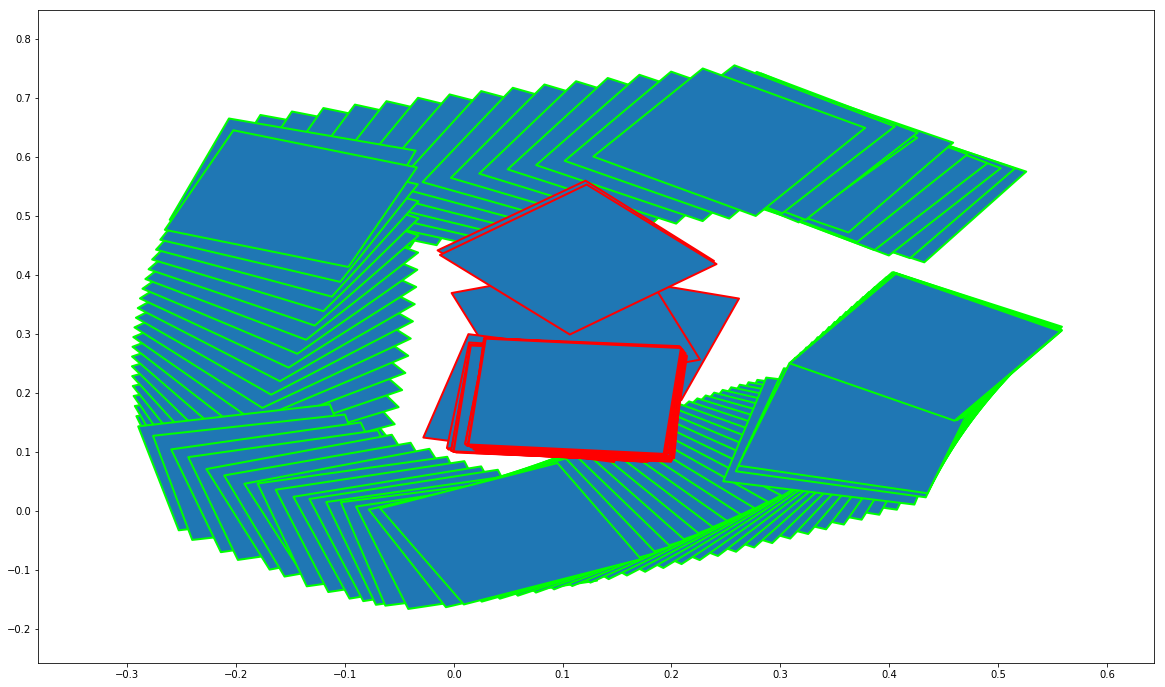

In [40]:
plot(object_data, 835 , 945)

In [100]:
import bisect
def interpolate_object_data( session_len, one_object_data ):
    new_one_object_data = {}
    sorted_keys = sorted(one_object_data.keys())
    for frame in range(session_len):
        if frame not in one_object_data:
            # missing frame
            frame_position = bisect.bisect_left(sorted_keys, frame)

            if frame_position == 0:
                # missing at the beginning
                new_one_object_data[frame] = one_object_data[sorted_keys[0]]
            elif frame_position == len(sorted_keys):
                # missing at the end
                new_one_object_data[frame] = one_object_data[sorted_keys[-1]]
            else:
                pre_key = sorted_keys[frame_position - 1]
                nex_key = sorted_keys[frame_position]
                pre = one_object_data[pre_key].transform
                nex = one_object_data[nex_key].transform
                
                p = (frame - pre_key)/(nex_key - pre_key)
                q = (nex_key - frame)/(nex_key - pre_key)
                transfrom = Transform2D ( nex.position * p + pre.position * q , 
                                         nex.rotation * p + pre.rotation * q, 
                                         nex.scale * p + pre.scale * q)
                new_one_object_data[frame] = Cube2D( transfrom )
        else:
            new_one_object_data[frame] = one_object_data[frame]
    return new_one_object_data

In [69]:
interpolated_object_data = {}
for object_name in object_data:
    interpolated_object_data[object_name] = interpolate_object_data(2881, object_data[object_name])

In [70]:
len(interpolated_object_data['Stella Artois'])

2881

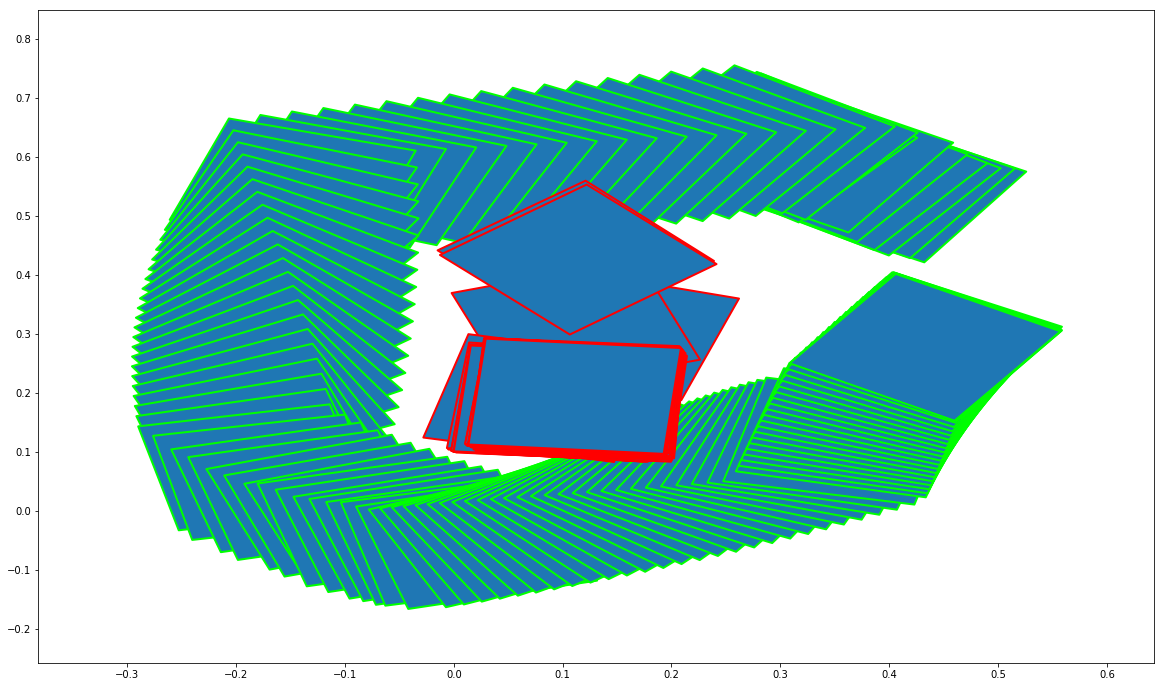

In [71]:
plot(interpolated_object_data, 835 , 945)

In [17]:
from qsrlib.qsrlib import QSRlib

In [18]:
object_data.keys()

dict_keys(['Shell', 'Stella Artois'])

In [20]:
qsrlib = QSRlib()



AttributeError: 'Cube2D' object has no attribute 'position'

In [24]:
from qsrlib.qsrlib import QSRlib, QSRlib_Request_Message
from qsrlib_io.world_trace import Object_State, World_Trace

from feature.project_table import project_markers, estimate_cube_2d
from utils import SESSION_OBJECTS, SESSION_LEN, BLOCK_SIZE, ROTATION_QUANTIZATION

In [80]:
def qsr_feature_extractor ( qsrlib, object_data, object_1_name, object_2_name, session_len ):
    '''
    feature_selection between two objects
    # of features = 13
    
    8 features here
    (o1.position, o2.position) - cardir, cardir_diff, argd, argd_diff, qtccs 4 features

    -- other features
    
    2 features
    quantized rotation of two objects
    1 feature
    quantized rotation difference between two objects
    2 features
    quantized difference of rotations btw two frames of two objects
    '''
    object_1 = object_data[object_1_name]
    object_2 = object_data[object_2_name]

    o1 = [Object_State(name="o1", timestamp=i, x=object_1[i].transform.position[0][0], y=object_1[i].transform.position[0][1]) 
            for i in range(session_len)]
    o2 = [Object_State(name="o2", timestamp=i, x=object_2[i].transform.position[0][0], y=object_2[i].transform.position[0][1]) 
            for i in range(session_len)]

    world = World_Trace()
    world.add_object_state_series(o1)
    world.add_object_state_series(o2)

    qsrlib_request_message = QSRlib_Request_Message(which_qsr=['cardir', 'argd', 'qtccs'], input_data=world, 
                    dynamic_args = {'cardir': {'qsrs_for': [('o1', 'o2')]},
                                    'argd': {'qsrs_for': [('o1', 'o2')], 
                                            'qsr_relations_and_values' : dict(("" + str(i), i * BLOCK_SIZE / 2) for i in range(20)) },
                                    'qtccs': {'qsrs_for': [('o1', 'o2')], 
                                              'quantisation_factor': 0.001, 'angle_quantisation_factor' : np.pi / 5,
                                              'validate': False, 'no_collapse': True
                                   }})

    # Number of features that you calculate the difference between two consecutive frames
    diff_feature = 2
    try:
        # pretty_print_world_qsr_trace(['cardir', 'mos', 'argd', 'qtccs'], qsrlib_response_message)
        qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

        # (#frame, 8)
        qsr_feature = turn_response_to_features([('o1,o2')], qsrlib_response_message, diff_feature)

        # rotation features
        quantized_r_1 = np.array([object_1[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
        quantized_r_2 = np.array([object_2[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
        quantized_diff = quantized_r_1 - quantized_r_2
        diff_quantized_r_1 = np.pad(np.ediff1d(quantized_r_1), (1,0), 'constant', constant_values = (0,))
        diff_quantized_r_2 = np.pad(np.ediff1d(quantized_r_2), (1,0), 'constant', constant_values = (0,))

        # column forms
        quantized_r_1.shape = (session_len, 1)
        quantized_r_2.shape = (session_len, 1)
        quantized_diff.shape = (session_len, 1)
        diff_quantized_r_1.shape = (session_len, 1)
        diff_quantized_r_2.shape = (session_len, 1)

        return np.concatenate([qsr_feature, quantized_r_1, quantized_r_2, quantized_diff, diff_quantized_r_1, diff_quantized_r_2], axis = 1)

    except ValueError as e:
        print (e)
        print ('Problem in data of length ' + str(len_data))
        return []

cdid = dict( (u, i) for (i, u) in enumerate( ['n', 'nw', 'w', 'sw', 's', 'se', 'e', 'ne', 'eq'] ))
mosd = dict( (u, i) for (i, u) in enumerate( ['s', 'm'] ))
qtcc_relations = dict( (u, i) for (i, u) in enumerate( ['-', '0', '+'] ))

def cardir_index ( cardir ):
    return cdid [cardir]

def mos_index ( mos ):
    return mosd [mos]

def qtcc_index ( qtcc_relation ):
    return qtcc_relations [qtcc_relation] - 1

'''
diff_feature: number of features at the beginning that need to create difference between two frames
all_feature: total number of features
'''
def turn_response_to_features(keys, qsrlib_response_message, diff_feature):
    feature_chain = []
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        features = []
        # print (qsrlib_response_message.qsrs.trace[t].qsrs.keys())
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]
                
                if 'cardir' in v.qsr:
                    f = v.qsr['cardir']
                    features.append(cardir_index(f))
                if 'argd' in v.qsr:
                    f = int( v.qsr['argd'] )
                    features.append(f)
        # Just to separate qtccs at the end of feature vectors
        
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]
                if 'qtccs' in v.qsr:
                    fs = v.qsr['qtccs']
                    features += [qtcc_index(f) for f  in fs.split(',')]
        
        # print features
        feature_chain.append(features)
    
    if len(feature_chain) == 0:
        return feature_chain

    # The first frame doesn't has qtcc relations
    feature_chain[0] += [0 for i in range(4)]

    feature_chain = np.array(feature_chain)
    
    print (feature_chain.shape)
    # number of features
    f_number = feature_chain.shape[1]

    # Feature that need to calculate diff
    # (#frame, diff_feature)
    need_diff_chain = feature_chain[:, :diff_feature]

    # Get the diff
    # (#frame - 1, diff_feature)
    diff_chain = np.diff(need_diff_chain, n=1, axis = 0)

    # (#frame, diff_feature)
    padded_diff_chain = np.pad(diff_chain, [(1,0), (0,0)], 'constant', constant_values = (0,))

    
    
    # Add for the first frame
    # (#frame, 2 * diff_feature + other_feature)
    diff_feature_chain = np.concatenate ( [need_diff_chain, padded_diff_chain, feature_chain[:, diff_feature:]], axis = 1 )
    
    print ('shape of diff_feature_chain %s' % str(diff_feature_chain.shape))
    return diff_feature_chain

In [81]:
features = qsr_feature_extractor(qsrlib, object_data, 'Stella Artois', 'Shell', 2881)

(2881, 6)
shape of diff_feature_chain (2881, 8)


In [36]:
object_data['Stella Artois'][1]

In [37]:
object_1 = object_data['Stella Artois']

In [39]:
o1 = [Object_State(name="o1", timestamp=i, x=object_1[i].transform.position[0], y=object_1[i].transform.position[1]) 
            for i in range(2881)]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [43]:
i = 0
print (object_1[i].transform.position)
Object_State(name="o1", timestamp=i, x=object_1[i].transform.position[0][0], y=object_1[i].transform.position[0][1]) 

[[ 0.44754734  0.57126873]]


In [61]:
object_1_name = 'Stella Artois'
object_2_name = 'Shell'
session_len = 2881

In [62]:
object_1 = object_data[object_1_name]
object_2 = object_data[object_2_name]

o1 = [Object_State(name="o1", timestamp=i, x=object_1[i].transform.position[0][0], y=object_1[i].transform.position[0][1]) 
        for i in range(session_len)]
o2 = [Object_State(name="o2", timestamp=i, x=object_2[i].transform.position[0][0], y=object_2[i].transform.position[0][1]) 
        for i in range(session_len)]

world = World_Trace()
world.add_object_state_series(o1)
world.add_object_state_series(o2)

In [63]:
qsrlib_request_message = QSRlib_Request_Message(which_qsr=['cardir', 'argd', 'qtccs'], input_data=world, 
                    dynamic_args = {'cardir': {'qsrs_for': [('o1', 'o2')]},
                                    'argd': {'qsrs_for': [('o1', 'o2')], 
                                            'qsr_relations_and_values' : dict(("" + str(i), i * BLOCK_SIZE / 2) for i in range(20)) },
                                    'qtccs': {'qsrs_for': [('o1', 'o2')], 
                                              'quantisation_factor': 0.001, 'angle_quantisation_factor' : np.pi / 5,
                                              'validate': False, 'no_collapse': True
                                   }})

In [64]:
qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

In [65]:
qsrlib_response_message

In [67]:
qsrlib_response_message.qsrs.trace[0].qsrs

{'o1,o2': <qsrlib_io.world_qsr_trace.QSR at 0x2a8c7bd0a20>}

In [84]:
qsr_feature = turn_response_to_features([('o1,o2')], qsrlib_response_message, 2)

(2881, 6)
shape of diff_feature_chain (2881, 8)


In [85]:
quantized_r_1 = np.array([object_1[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
quantized_r_2 = np.array([object_2[i].transform.rotation // ROTATION_QUANTIZATION for i in range(session_len)])
quantized_diff = quantized_r_1 - quantized_r_2
diff_quantized_r_1 = np.pad(np.ediff1d(quantized_r_1), (1,0), 'constant', constant_values = (0,))
diff_quantized_r_2 = np.pad(np.ediff1d(quantized_r_2), (1,0), 'constant', constant_values = (0,))

# column forms
quantized_r_1.shape = (session_len, 1)
quantized_r_2.shape = (session_len, 1)
quantized_diff.shape = (session_len, 1)
diff_quantized_r_1.shape = (session_len, 1)
diff_quantized_r_2.shape = (session_len, 1)

In [86]:
qsr_feature.shape

(2881, 8)

In [87]:
u = np.concatenate([qsr_feature, quantized_r_1, quantized_r_2, quantized_diff, diff_quantized_r_1, diff_quantized_r_2], axis = 1)

In [88]:
u.shape

(2881, 13)

In [89]:
features[:20,:]

array([[ 7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  8.,  0.,  0.,  0.],
       [ 7.,  4.,  0.,  0., -1.,  0.,  0.,  0.,  8.,  8.,  0.,  0.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0., -1.,  1.,  8.,  8.,  0.,  0.,  0.],
       [ 7.,  4.,  0.,  0., -1.,  0.,  0.,  0.,  7.,  8., -1., -1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  8., -1.,  0.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  1.,  0.,  8.,  8.,  0.,  1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0., -1.,  8.,  8.,  0.,  0.,  0.],
       [ 7.,  4.,  0.,  0., -1.,  0., -1.,  1.,  7.,  8., -1., -1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0., -1.,  7.,  8., -1.,  0.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  8.,  0.,  1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  8., -1., -1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  1.,  0.,  8.,  8.,  0.,  1.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  8.,  0.,  0.,  0.],
       [ 7.,  4.,  0.,  0.,  0.,  0., 

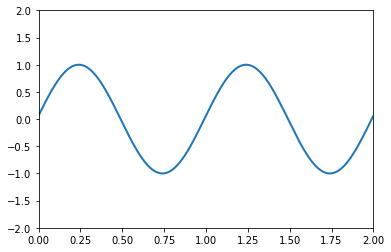

In [7]:


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [11]:
import io
import base64
from IPython.display import HTML

video = io.open('basic_animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [107]:
def animate (object_data, from_frame, to_frame, min_x = -.6, max_x = 1, min_y =  -.6, max_y = 1, name = "event.mp4"):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(min_x, max_x, 0.1))
    ax.set_yticks(np.arange(min_y, max_y, 0.1))
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    fig.set_size_inches(20, 12)

    ax.autoscale()
    ax.margins(0.1)
    
#     # initialization function: plot the background of each frame
#     def init():
#         ax.clear()
#         ax.set_xticks(np.arange(-2, 2, 0.1))
#         ax.set_yticks(np.arange(-2, 2, 0.1))
#         ax.set_xlim([-2, 2])
#         ax.set_ylim([-2, 2])
#         return ax,

    # animation function.  This is called sequentially
    def animate(i):
        lc = mc.PolyCollection([object_data[object_name][i + from_frame].get_markers() for object_name in object_data], 
                               edgecolors=[colors[object_name] for object_name in object_data], 
                               facecolors=[colors[object_name] for object_name in object_data], linewidths=[2,2])
        ax.clear()
        ax.set_xticks(np.arange(min_x, max_x, 0.1))
        ax.set_yticks(np.arange(min_y, max_y, 0.1))
        ax.set_xlim([min_x, max_x])
        ax.set_ylim([min_y, max_y])
        ax.add_collection(lc)
        return lc,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=to_frame - from_frame, interval=20, blit=True)

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    anim.save(name, fps=30, extra_args=['-vcodec', 'libx264'])
    
    plt.show()

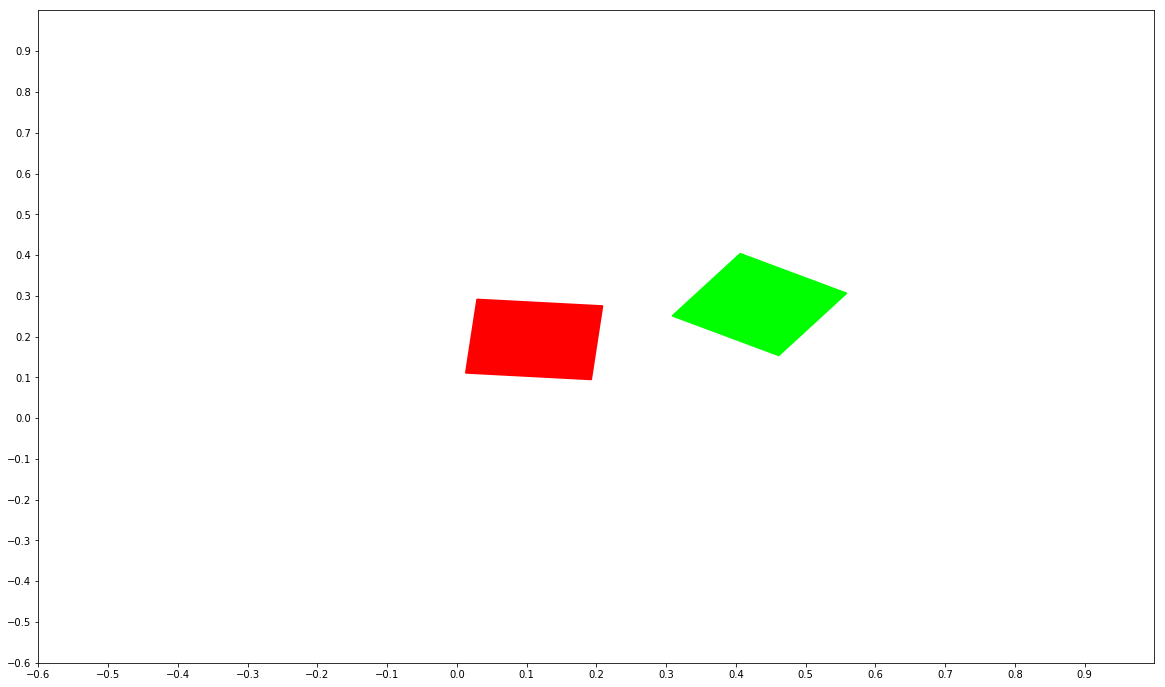

In [81]:
animate(interpolated_object_data, 835 , 945, "slide_around.mp4")

In [83]:
colors = {'Shell': (1, 0, 0, 1), "Stella Artois" : (0,1,0,1), "Pepsi" : (0,0,1,1) }

In [86]:
row_session = load_one_param_file(os.path.join( DATA_DIR, 'MakeARow', 'Session1', 'files.param'))

'NoneType' object has no attribute 'findall'


In [93]:
row_object_data = project_to2d_(row_session)

2561
3303
430
897
449
1232
121
566
2446
3802
4134
4162
2619
4311
4005
1153
1672
1762
2893
3364
1095


D:\git\learn-to-perform\feature\project_table.py:116: RuntimeWarning: invalid value encountered in true_divide
  side /= norm(side)
C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\numpy\linalg\linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


2884
2473
2835
2654
431
3553
256
549
286
1448
3700
3116
158
2830
2735
3048
3299
1473
454
1054
2672
131
140
146
1060
3560
903
3125
2069
2692
1737
3949
3136
106
1129
3539
3887
2158
3716
2014
1683
844
4326
323
2658
171
448
852
1553
618
218
3953
2553
2463
3827
3470
1178
4287
2050
2480
2602
4325
239
1089
4229
3783
319
4051
1400
3972
2130
3166
2674
345
3219
2801
3996
2865
2488
406
2533
304
3272
1763
2087
1495
2803
3258
1534
4215
115
2054
116
1565
2588
2459
4270
1527
565
1990
1321
4253
367
612
3808
4015
929
1499
1447
1821
4210
3978
1128
3242
1964
1999
1962
3358
4244
4333
180
4271
2841
183
2501
4014
260
3243
1869
166
909
499
2852
3523
227
3682
372
2647
873
1599
4002
2392
429
526
908
3214
2513
580
3839
3772
904
3159
2403
2363
2696
3333
4137
2154
3184
1759
98
3683
4295
3233
1708
1482
402
3329
2022
3275
2769
1150
2824
87
1774
4169
860
3174
2524
109
2850
3405
4238
2507
4045
1912
2116
1825
2837
4230
289
1159
1099
4331
2664
4016
534
1595
2627
3056
2038
2450
2646
4340
669
867
609
178
1775
285
1875
12

C:\Anaconda3\envs\tensorflow-cpu\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars



40
3366
1053
870
3062
380
1855
1754
2502
2745
3984
287
2703
1597
4144
2397
3954
1819
2141
3974
1000
2758
3227
2780
2516
4341
24
1915
2520
3345
3138
1539
3823
2810
1798
2481
2902
3153
3223
1716
1189
4266
1552
2051
3221
2475
520
1227
514
1611
1679
4007
1163
4207
2796
3259
3759
3126
1106
2691
2816
1124
1924
90
506
2600
3564
2002
13
1940
195
1777
2146
3050
2725
177
3831
3975
3146
1934
1771
2111
3225
662
3544
267
303
2714
2107
3154
3536
3353
465
2676
1690
4264
3284
569
2456
3490
1545
3806
154
305
2741
4203
922
4139
1526
3200
1113
224
3201
2693
2562
1583
460
539
191
1750
2360
3108
1593
2478
1120
48
3982
33
4057
4323
2771
392
2045
2462
2775
3314
3715
2375
1096
2147
1725
2895
1445
3421
3943
1954
2843
1726
2809
1016
3880
485
331
1050
4259
2678
261
3993
4155
3994
274
3543
2564
1666
1240
2556
3250
2371
2495
3882
3079
321
284
2787
413
2716
2537
2030
3480
2474
4339
4180
4352
2557
2162
1183
3999
3535
3417
2425
4127
1117
1141
1852
3469
2899
3686
1108
2853
3065
1460
1746
3781
1919
2019
2606
375
63
10

3805
3813
2679
362
3869
558
3030
263
3527
3676
1112
586
297
2036
3310
671
530
57
2671
2594
2175
3799
1596
496
3788
3344
2505
1015
2856
1256
666
2007
884
4176
4241
2950
1059
2167
3465
3192
2941
3555
4272
513
1019
2157
3905
1605
2786
1935
3840
941
203
553
2656
2546
1972
900
461
2547
3699
2621
17
221
1048
4047
3271
3800
3529
3456
3551
126
219
326
4
1408
3052
4011
3461
2511
3140
3725
3188
2704
2840
1612
515
888
2024
1559
3158
415
1486
3969
562
451
4256
112
2510
2644
3906
2085
2430
251
1998
2082
536
4024
839
1971
1014
2012
4345
1538
1692
3198
2668
3545
2120
2388
237
3897
2390
3432
4346
2043
1845
2565
3325
1230
3661
173
4026
100
1192
3323
2149
4167
407
3547
4296
3445
583
3976
76
1789
1600
401
2788
861
3723
80
1085
1174
3361
4228
3524
186
1467
1997
573
4046
3765
3273
2648
50
2802
1684
3404
2677
3442
1046
4027
3698
355
3068
1911
1064
2792
2740
1902
280
3819
1160
1517
3152
1126
582
1674
1887
4342
1093
1254
2577
4299
3558
1041
71
3191
3963
3486
3249
1976
2764
334
3151
2722
2081
0
1786
3768
3458


872
733
1749
3266
3118
483
964
12
2400
1541
3327
2613
2669
1476
333
2795
3349
2325
420
3613
551
257
4198
887
1243
1608
879
3745
1930
2664
621
324
1042
1305
3463
3234
3870
1891
2831
1392
2821
1253
798
236
2336
2697
1094
2010
457
1343
947
2594
2885
1979
4096
3877
597
3981
790
2267
4107
4156
1880
858
3644
3693
4097
3901
1088
2349
2713
4232
2331
209
1489
3784
537
1906
3100
3891
3485
3375
1864
241
88
921
207
1144
601
3584
1543
1623
2739
555
2900
1337
4185
3929
2912
1602
1148
432
3359
3422
616
405
3370
1925
3257
340
1879
328
738
2274
777
108
726
1359
1529
4125
1087
3867
3986
4293
857
1890
3385
1549
619
1554
1385
1035
3128
3922
1494
2354
4217
250
1152
1172
531
3268
1291
3412
4020
3992
3340
362
2389
456
3462
4289
1768
3786
521
884
1946
1605
604
3244
3582
3594
766
2618
1724
1892
936
1014
2832
237
461
1293
1278
242
1632
527
3404
2903
1757
3985
3426
3132
3339
3435
1007
334
1200
4120
1478
3885
2776
3549
3500
4027
2793
2732
547
710
1424
436
489
1005
3231
4140
2376
3302
3451
255
2782
1784
1040
3113


78
2615
3415
2294
3763
3961
1525
2008
3196
1029
2764
243
3659
2299
1339
1625
1294
355
3680
3245
910
2750
1719
1767
1769
2561
3303
430
449
1232
4040
566
966
2446
3802
4134
1375
2619
4311
3672
1153
1672
3937
1762
2893
4193
3364
1095
3818
2473
2835
2654
431
256
549
286
3700
3116
2830
3742
2735
2942
1473
454
1054
2672
131
3929
1060
3125
4037
2069
2692
1737
3848
3394
2280
3136
106
1129
4237
697
3887
792
1657
2014
1683
1633
2261
4326
447
794
2658
1344
448
852
3953
3970
2463
3827
2285
1178
3888
2050
771
2480
2602
1089
4229
957
319
4051
1400
296
2245
833
3166
2674
345
681
2801
3996
2865
2807
406
304
1763
2087
1495
51
330
3736
4215
1326
2054
2217
1205
3092
1855
1565
2588
3379
1387
2459
1527
565
1990
1321
4253
612
3808
4015
929
1499
2184
1821
4210
1340
789
1128
1964
1999
1962
3358
4244
4333
180
2841
3727
1398
183
3791
2335
803
4014
260
2287
963
4287
909
499
2852
1597
227
1860
2647
873
1599
4002
2392
429
1073
1502
3214
580
3839
4297
4119
1354
3159
2403
2696
3333
4137
3184
1648
1759
98
1171
4295
1

1812
1506
4239
674
1481
4231
4105
973
2560
2842
3846
1118
3164
44
1537
3475
1186
2981
2585
2603
1551
2347
3332
427
2076
4280
1823
3810
1031
2749
111
4109
3109
107
713
824
1413
1920
2592
2301
4304
2575
4090
1322
4079
208
716
64
2638
3112
2839
211
2836
940
875
3875
2330
3423
2887
1391
2958
1498
2997
103
4319
3494
3121
870
1803
1671
2042
1377
3934
3099
2055
885
3147
3178
3393
458
2818
1026
1797
2694
721
1905
197
129
3229
1381
1627
3001
1824
3988
2834
284
1464
2622
3838
453
4143
2448
1909
799
3931
4023
3957
1766
1653
1142
85
1808
599
588
3850
3410
1265
1122
3371
1842
332
2095
1682
4012
361
1761
3186
568
210
1773
1604
437
3101
2611
4294
125
1497
192
3305
3408
2312
3010
1086
1080
3378
3837
3144
1689
2440
2625
946
2871
598
1806
1677
1035
128
3865
1740
1508
2863
3076
229
490
1676
3722
2730
1598
3868
3331
3861
847
2568
1056
3687
925
3218
3072
201
2476
1235
822
1702
2248
1181
1970
1036
2318
4074
951
1063
252
4141
439
615
1699
1123
4099
1881
1218
563
2429
3969
3889
3703
2762
3903
881
2308
1191
27

In [101]:
interpolated_row_data = {}
for object_name in row_object_data:
    interpolated_row_data[object_name] = interpolate_object_data(4360, row_object_data[object_name])

In [102]:
print(len(interpolated_row_data['Pepsi']))
print(len(interpolated_row_data['Shell']))
print(len(interpolated_row_data['Stella Artois']))

4360
4360
4360


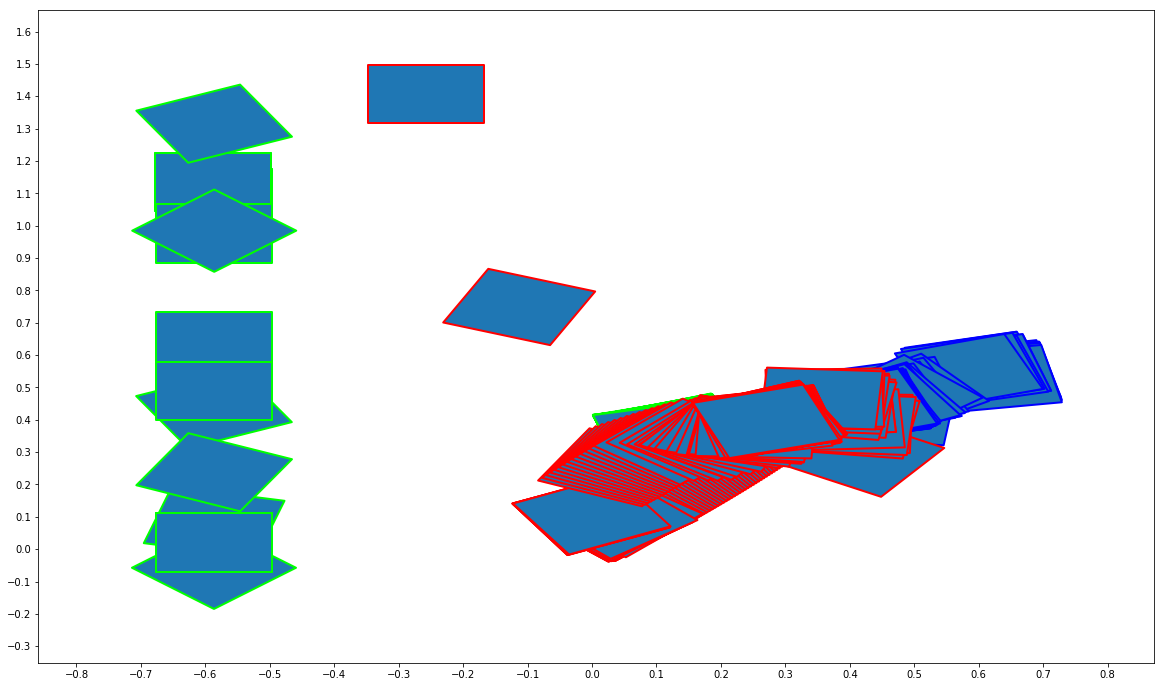

In [95]:
plot(interpolated_row_data, 0 , 300)

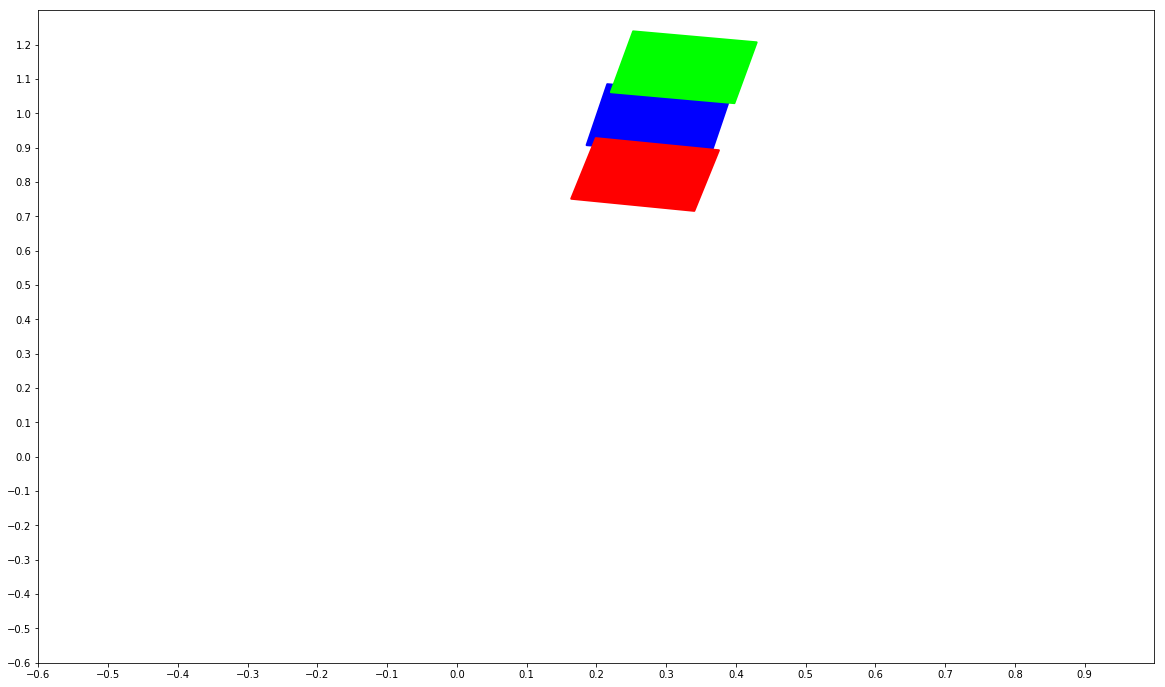

In [109]:
animate(interpolated_row_data, 428 , 577, name = "make_a_row.mp4", max_y = 1.3)

In [118]:
for frame in range(428,577):
    print((frame,str(row_object_data['Shell'][frame])))

(428, 'Cube :[-0.03890622  0.51444611], [ 0.06818315  0.36976762], [-0.07649534  0.26267825], [-0.18358471  0.40735674]')
(429, 'Cube :[-0.03689236  0.51248421], [ 0.06831116  0.36642868], [-0.07774438  0.26122516], [-0.18294789  0.4072807 ]')
(430, 'Cube :[-0.03659282  0.510764  ], [ 0.06710434  0.36363516], [-0.0800245   0.25993799], [-0.18372167  0.40706684]')
(431, 'Cube :[-0.03637862  0.51172118], [ 0.06798029  0.36506097], [-0.07867992  0.26070206], [-0.18303883  0.40736227]')
(432, 'Cube :[-0.03544719  0.51059402], [ 0.06564433  0.36166281], [-0.08328688  0.26057129], [-0.18437839  0.4095025 ]')
(433, 'Cube :[-0.03638752  0.51055898], [ 0.06648535  0.3628526 ], [-0.08122103  0.25997974], [-0.18409389  0.40768612]')
(434, 'Cube :[-0.03713225  0.51271985], [ 0.06891461  0.36727549], [-0.07652976  0.26122863], [-0.18257662  0.406673  ]')
(435, 'Cube :[-0.03637862  0.51172118], [ 0.06798029  0.36506097], [-0.07867992  0.26070206], [-0.18303883  0.40736227]')
(436, 'Cube :[-0.0362212

KeyError: 524

In [119]:
from feature.project_table import recover_missing

In [133]:
for frame_no in range(500, 520):
    if str(frame_no) in row_session[SESSION_OBJECTS]['Shell']:
        print (str(frame_no), str(row_session[SESSION_OBJECTS]['Shell'][str(frame_no)]))

500 {521: array([-0.4786244 , -0.2158408 ,  1.11899996, -0.49973151, -0.1889441 ,
        1.199     , -0.41545451, -0.18029331,  1.22800004, -0.3927505 ,
       -0.20951059,  1.13399994], dtype=float32), 303: array([-0.46737739, -0.33793151,  1.12      , -0.47237059, -0.25931779,
        1.097     , -0.3837696 , -0.24875949,  1.11699998, -0.3827011 ,
       -0.3314634 ,  1.14100003], dtype=float32)}
501 {521: array([-0.47819671, -0.21564791,  1.11800003, -0.5001483 , -0.1891017 ,
        1.20000005, -0.41443959, -0.1798528 ,  1.22500002, -0.39205781,
       -0.20914111,  1.13199997], dtype=float32), 303: array([-0.46821201, -0.33853501,  1.12199998, -0.47280121, -0.25955421,
        1.09800005, -0.38445669, -0.2492049 ,  1.11899996, -0.3823657 ,
       -0.33117291,  1.13999999], dtype=float32)}
502 {521: array([-0.47737941, -0.2169314 ,  1.10899997, -0.4993147 , -0.1887866 ,
        1.19799995, -0.41511631, -0.1801465 ,  1.227     , -0.39205781,
       -0.20914111,  1.13199997], dtype=

In [139]:
t = '-∞,-∞,-∞,-0.3808005,-0.2117657,1.163,-0.4368422,-0.2304399,1.597,-0.3324033,-0.2401299,1.573'

In [140]:
q = t.replace('∞', 'inf')

In [141]:
q

'-inf,-inf,-inf,-0.3808005,-0.2117657,1.163,-0.4368422,-0.2304399,1.597,-0.3324033,-0.2401299,1.573'

In [142]:
def values_to_array( v ):
    values = v.split(',')

    return np.array( values, dtype = np.float32 )

In [143]:
values_to_array(q)

array([       -inf,        -inf,        -inf, -0.38080049, -0.21176571,
        1.16299999, -0.4368422 , -0.2304399 ,  1.597     , -0.3324033 ,
       -0.2401299 ,  1.57299995], dtype=float32)